## A/B тест

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2025-03-28 по 2025-04-03 включительно. Для эксперимента были задействованы 2 и 1 группы. 

- В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

- Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [3]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib

from scipy import stats
%matplotlib inline

In [4]:
# Подключение к базе
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250420'
}

In [5]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250420.feed_actions
WHERE toDate(time) between '2025-03-28' and '2025-04-03'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()


,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

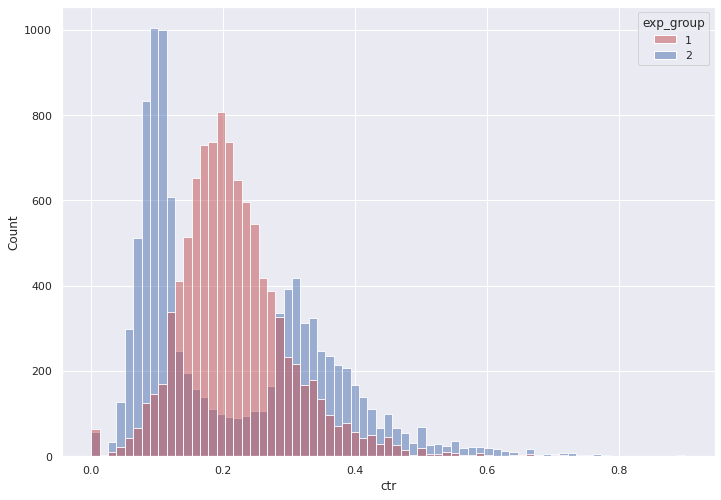

In [7]:
groups = sns.histplot(data = df,
                     x='ctr',
                     hue='exp_group',
                     palette = ['r', 'b'],
                     alpha=0.5,
                     kde=False)

In [8]:
#T-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [9]:
#тест манна-уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

### Промежуточный вывод
- Исходя из проведенных статистических тестов (t-тест и тест Манна-Уитни) и построении графиков распределения ctr для обеих групп, можно сделать некоторые выводы.

- CTR у группы B принимает форму бимодального распределения, в то время, как распределение группы А больше похоже на нормальное.

- Из-за такого распределения p-value t-теста может показывать некорректные результаты, показывая, что группы не имеют статистически значимых различий.

- Для групп с нестандартным распределением больше подойдет тест Манна-Уитни, который, в свою очередь, уже указывает на статистически значимые различия между группами.
С p-value = 4.632205841806026e-45.

### Сглаженный CTR

Text(0, 0.5, 'Частота')

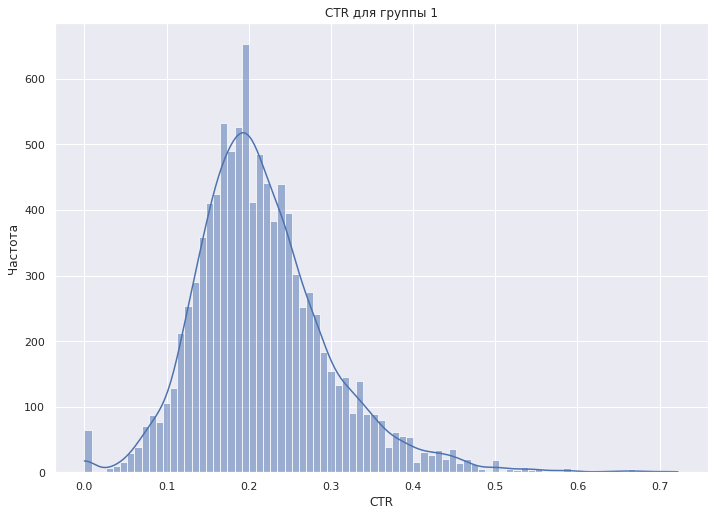

In [20]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-03-28' and '2025-04-03'
and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_2 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 2].views.sum()
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr,
            kde = True)
plt.title('CTR для группы 1')
plt.xlabel('CTR')
plt.ylabel('Частота')

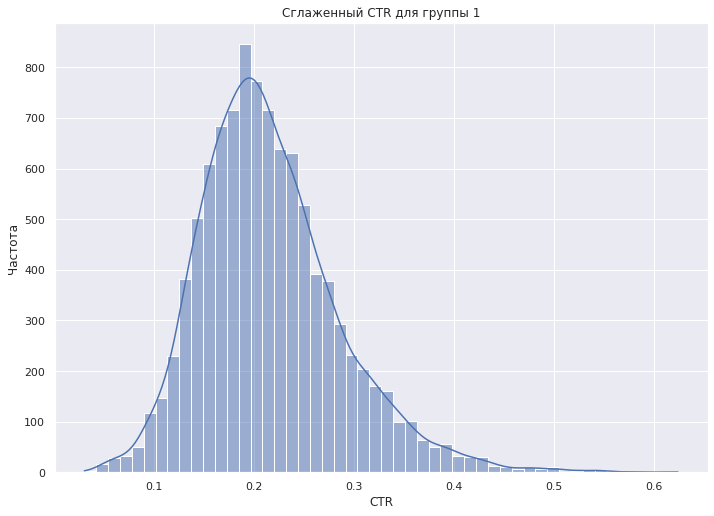

In [24]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, bins=50, kde=True)
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.title('Сглаженный CTR для группы 1')
plt.show()

Text(0, 0.5, 'Частота')

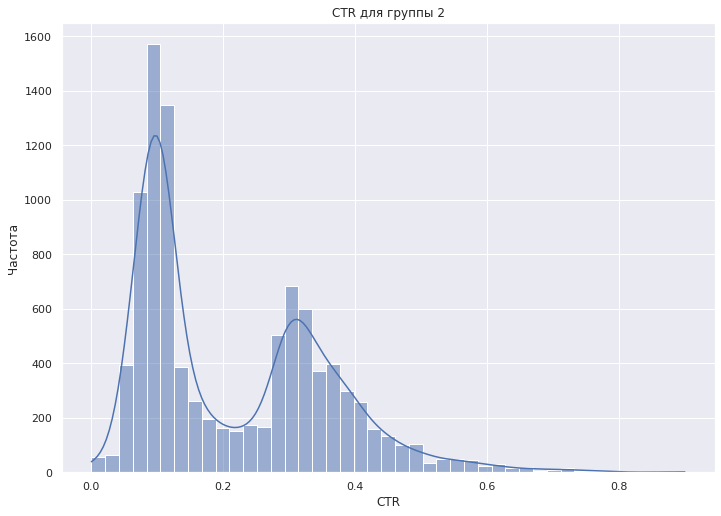

In [21]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr,
            kde = True)
plt.title('CTR для группы 2')
plt.xlabel('CTR')
plt.ylabel('Частота')

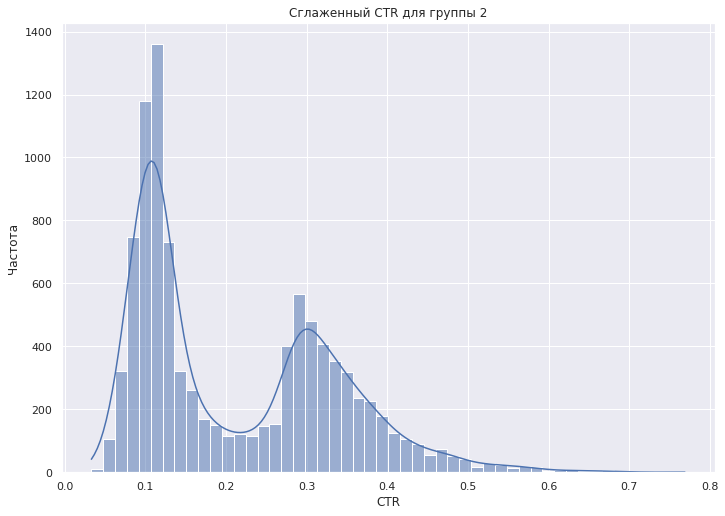

In [26]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, bins=50, kde=True)
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.title('Сглаженный CTR для группы 2')
plt.show()

In [27]:
#тест Манна-Уитни
stats.mannwhitneyu(group1['smothed_ctr'], 
                   group2['smothed_ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55336744.5, pvalue=2.5700858994640444e-47)

### Промежуточный вывод по сглаженному CTR

- Опять же, так как распределение 2 группы бимодальное, думаю, что не имеет смысла проводить t-тест, сразу перейдем к Манна-Уитни.

- Который показывает p-value=2.5700858994640444e-47, что свидетельствует о наличии между группами статистически значимых отличий.

### Пуассоновский бутстреп

In [28]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
    (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

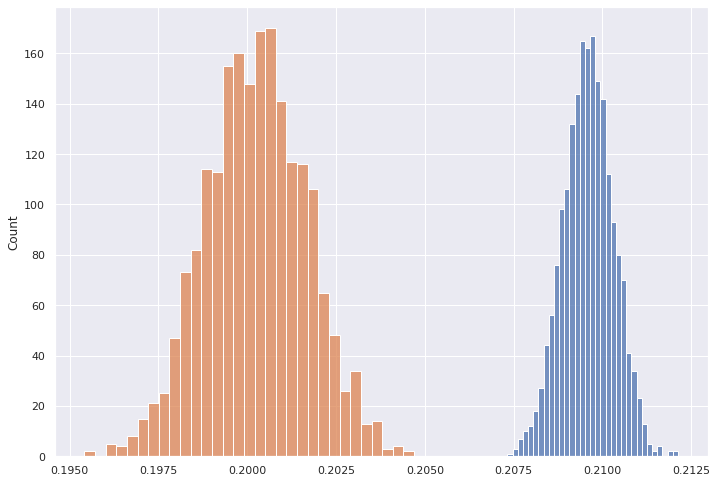

In [29]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

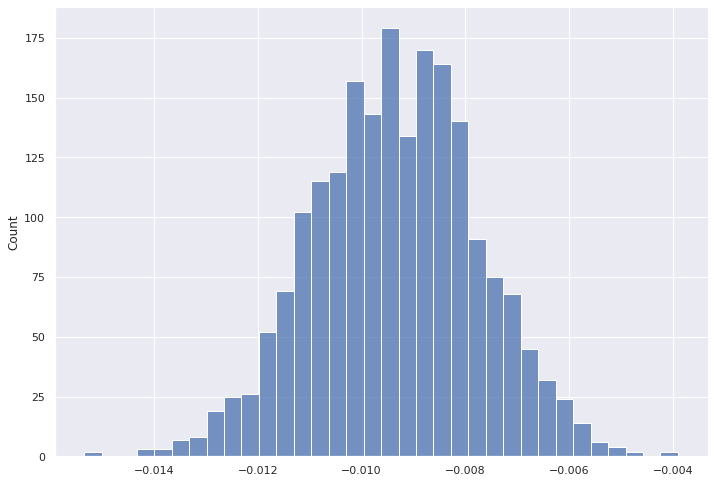

In [31]:
sns.histplot(ctr2 - ctr1)

### Промежуточный вывод по пуассоновскому бутстрепу

- Распределения CTR между двумя группами абсолютно никак не пересекаются на гистограмме.

- И при расчете разницы между глобальными CTR, доверительный интервал располагается в отрицательных значениях.

- В таком случае, мы можем также считать, что различия между нашими выборками статистически значимые.

### Бакетное преобразование

In [42]:
q = """
SELECT exp_group, bucket,
sum(likes)/sum(views) as bucket_ctr,
quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
xxHash64(user_id)%50 as bucket,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2025-03-28' and '2025-04-03'
and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr,
                    df[df.exp_group == 2].bucket_ctr,
                    alternative = 'two-sided')


MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [43]:
#t-тест
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr,
                df[df.exp_group == 2].bucket_ctr,
                equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

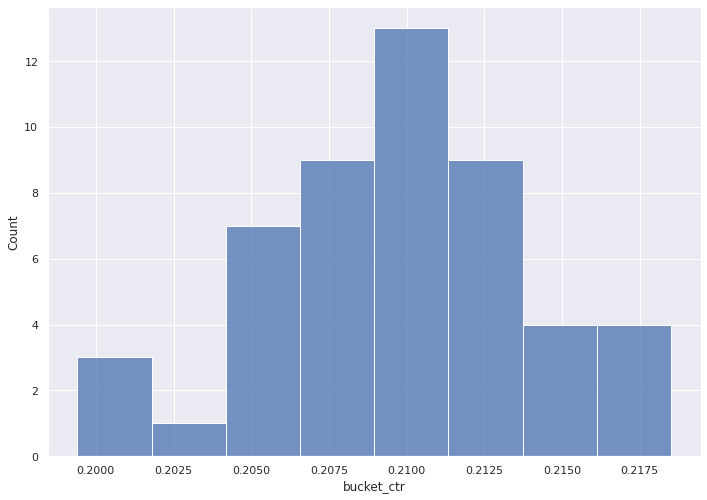

In [38]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

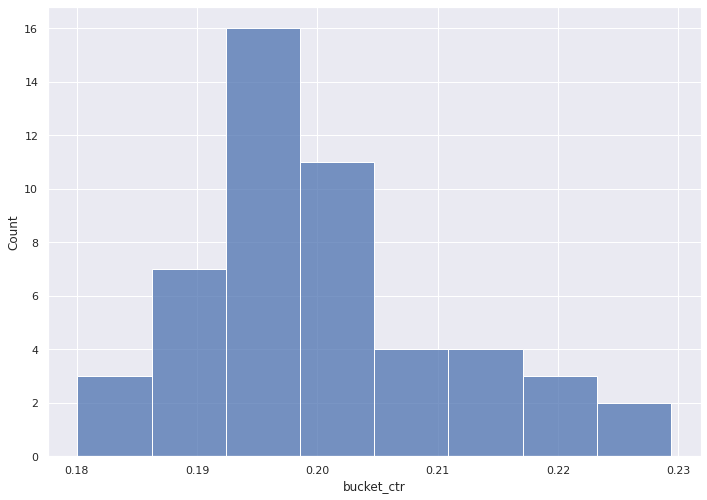

In [39]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

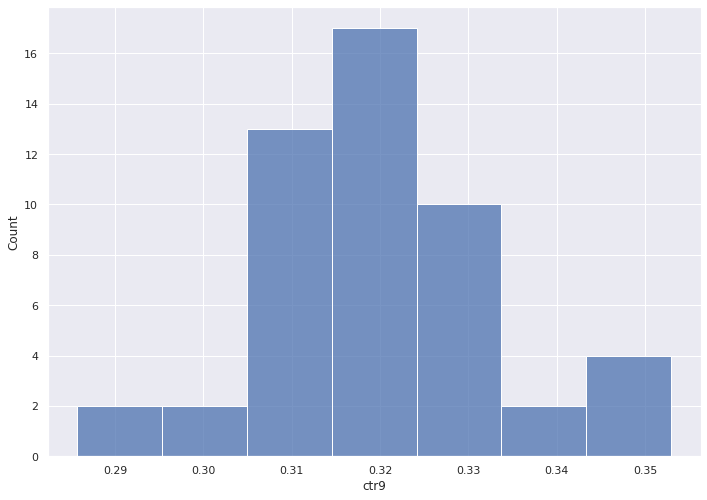

In [40]:
sns.histplot(df[df.exp_group == 1].ctr9);

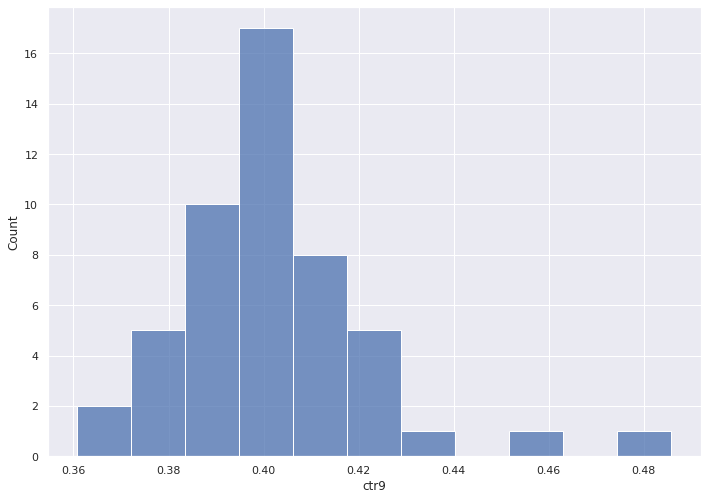

In [41]:
sns.histplot(df[df.exp_group == 2].ctr9);

In [44]:
#тест Манна-Уитни на 90% квантиле
stats.mannwhitneyu(df[df.exp_group == 1].ctr9, 
                   df[df.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.7601631082665925e-18)

### Промежуточный вывод по бакетному преобразованию

- Тест Манна-Уитни на бакетном преобразовании показал результат pvalue=4.592644937473873e-07. Это показывает также, что различия между группами статистически значимо.

- Тест Манна-Уитни на 90% квантиле выборок также показывает достаточно низкий результат pvalue=6.7601631082665925e-18. Исходя из этого, также делаем вывод, что различия в выборкам статистически значимо.

## Итоговый вывод

### Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

Такое могло произойти по нескольким причинам:

- Новый алгоритм не привел к предполагаем улучшения по увеличению кликабельности на предлагаемых постах;
- Могли быть различные технические проблемы на стороне сервиса;
- Но и также возможно, что пользователи стали проводить больше времени за просмотром постов, но при этом меньше их лайкали. Что может быть также улучшением для компании.

### Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит. При выполнении задания важно обосновать и аргументировать ваш вывод.

Если для компании показатель CTR имеет решающую роль для понимания успешности внедренных алгоритмов, то конечно по всем проведенным тестам можно сделать вывод, что внедрять новый алгоритм на данный момент не стоит. Или предварительно его стоит как-то доработать и провести дополнительные тесты после нововведений.

Такие выводы получились по следующим причинам:
- Глобальный CTR стал ниже на несколько процентов, на группе с новым алгоритмом;
- Все тесты показали, что имеются статистически значимые различия между выбранными группами.